In [1]:
from eva_cttv_pipeline.clinvar_xml_utils.clinvar_xml_utils.clinvar_xml_utils import *
from consequence_prediction.repeat_expansion_variants.clinvar_identifier_parsing import parse_variant_identifier

import os
import sys
import urllib
import requests
import xml.etree.ElementTree as ElementTree
from collections import Counter

import hgvs.parser
from hgvs.exceptions import HGVSParseError

import numpy as np
import pandas as pd

In [2]:
sys.path.append('../')
from gather_stats import counts

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
parser = hgvs.parser.Parser()

In [14]:
PROJECT_ROOT = '/home/april/projects/opentargets'

# dump of all records with no functional consequences: June consequence pred + ClinVar 6/26/2021
no_consequences_path = os.path.join(PROJECT_ROOT, 'no-consequences.xml.gz')
dataset = ClinVarDataset(no_consequences_path)

## Gather counts

Among records with no functional consequences
* how many of each variant type
* how many have hgvs, sequence location w/ start/stop position at least, cytogenic location
* of those with hgvs, how many can the library parse?
    * how many can our code parse?

In [ ]:
total_count, variant_type_hist, other_counts, exclusive_counts = counts(no_consequences_path, PROJECT_ROOT)

In [7]:
print(total_count)

17649


<BarContainer object of 15 artists>

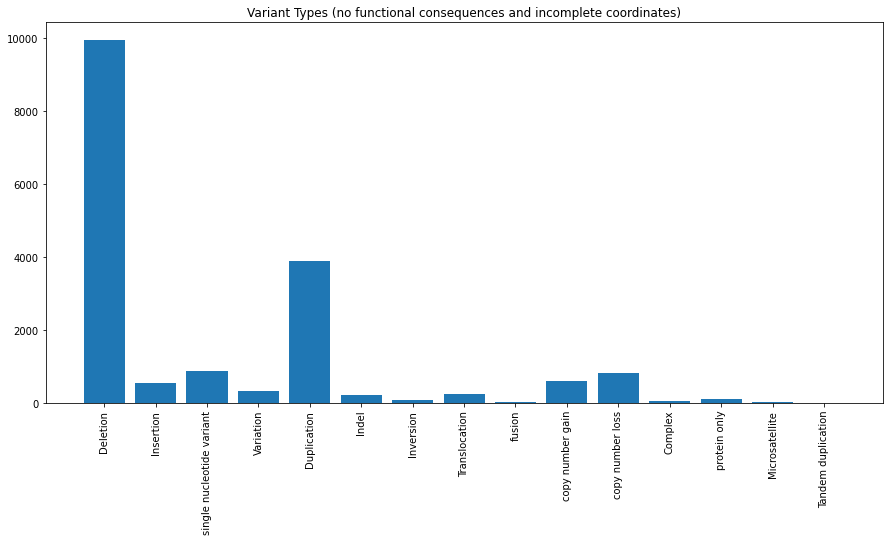

In [8]:
plt.figure(figsize=(15,7))
plt.xticks(rotation='vertical')
plt.title('Variant Types (no functional consequences and incomplete coordinates)')
plt.bar(variant_type_hist.keys(), variant_type_hist.values())

In [9]:
variant_type_hist

Counter({'Deletion': 9937,
         'Insertion': 552,
         'single nucleotide variant': 864,
         'Variation': 311,
         'Duplication': 3875,
         'Indel': 213,
         'Inversion': 73,
         'Translocation': 230,
         'fusion': 10,
         'copy number gain': 596,
         'copy number loss': 813,
         'Complex': 63,
         'protein only': 99,
         'Microsatellite': 12,
         'Tandem duplication': 1})

<BarContainer object of 8 artists>

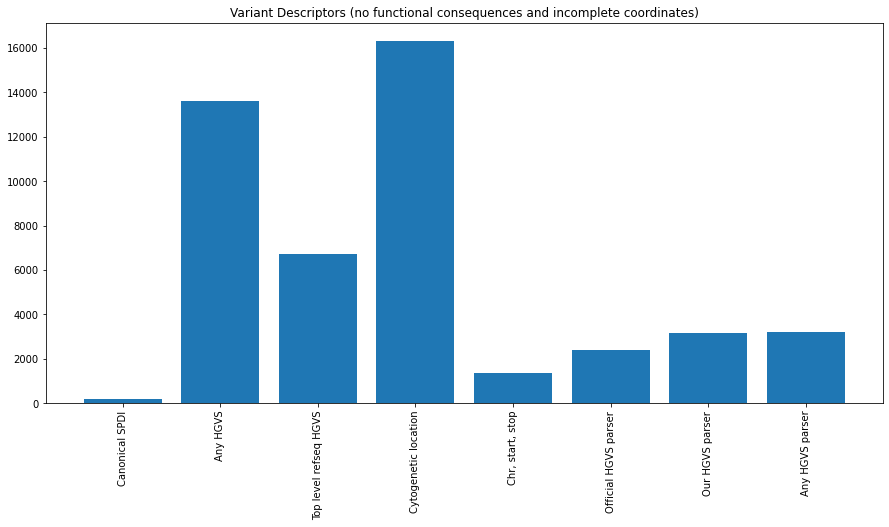

In [10]:
plt.figure(figsize=(15,7))
plt.xticks(rotation='vertical')
plt.title('Variant Descriptors (no functional consequences and incomplete coordinates)')
plt.bar(other_counts.keys(), other_counts.values())

In [11]:
other_counts

{'Canonical SPDI': 183,
 'Any HGVS': 13619,
 'Top level refseq HGVS': 6730,
 'Cytogenetic location': 16317,
 'Chr, start, stop': 1344,
 'Official HGVS parser': 2402,
 'Our HGVS parser': 3165,
 'Any HGVS parser': 3226}

In [12]:
def print_link_for_type(variant_type, min_score=-1):
    for record in dataset:
        if record.measure:
            m = record.measure
            if m.has_complete_coordinates:
                continue

            if m.variant_type == variant_type and record.score >= min_score:
                print(f'https://www.ncbi.nlm.nih.gov/clinvar/{record.accession}/')

In [ ]:
print_link_for_type('Microsatellite', min_score=1)

### Examples

Some hand-picked examples of complex variants from ClinVar.  For each type I tried to choose at least one that seemed "typical" and one that was relatively high quality to get an idea of the variability, but no guarantees for how representative these are.

* Duplication
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/1062574/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/89496/
* Deletion
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/1011851/
* Inversion
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/268016/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/90611/
* Translocation
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/267959/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/267873/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/1012364/
* copy number gain
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/523250/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/870516/
* copy number loss
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/1047901/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/625801/
* Complex
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/267835/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/585332/

### Appendix A: Marcos' questions

* What do the HGVS parser numbers mean?
    * This is the number of records which had at least one HGVS descriptor for which the specified parser was able to extract _some_ information.  For the official parser this means not throwing an exception; for our parser this means returning some non-`None` properties (though note our parser was originally written for the repeat expansion pipeline).
* What's the total number of HGVS we can parse with either parser?
    * added to the above chart.
* From the variants with cytogenetic location, how many did not have any of the other descriptors, if any?
    * see below

<BarContainer object of 3 artists>

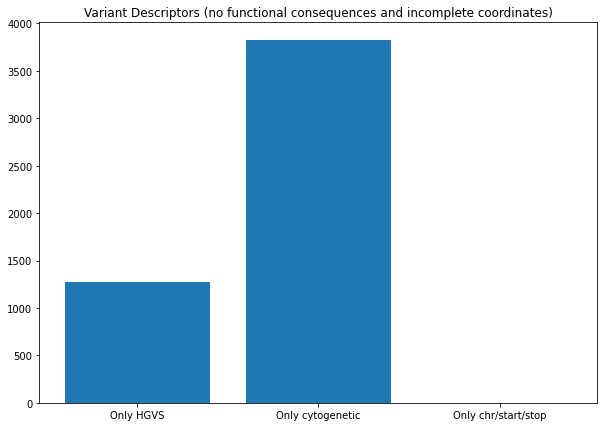

In [16]:
plt.figure(figsize=(10,7))
plt.title('Variant Descriptors (no functional consequences and incomplete coordinates)')
plt.bar(exclusive_counts.keys(), exclusive_counts.values())

In [17]:
exclusive_counts

{'Only HGVS': 1277, 'Only cytogenetic': 3821, 'Only chr/start/stop': 0}

### Appendix B: More HGVS parsing exploration

HGVS python library [doesn't support ranges](https://github.com/biocommons/hgvs/issues/225).

[VEP API](https://rest.ensembl.org/#VEP) has some limited support for HGVS.

In [29]:
def try_to_parse(hgvs):
    try:
        parser.parse_hgvs_variant(hgvs)
        print(hgvs, 'SUCCESS')
    except:
        print(hgvs, 'FAILED')


try_to_parse('NC_000011.10:g.(?_17605796)_(17612832_?)del')
try_to_parse('NC_000011.10:g.(17605790_17605796)_(17612832_1761283)del')
try_to_parse('NC_000011.10:g.17605796_17612832del')
try_to_parse('NC_000011.10:g.?_17612832del')

NC_000011.10:g.(?_17605796)_(17612832_?)del FAILED
NC_000011.10:g.(17605790_17605796)_(17612832_1761283)del FAILED
NC_000011.10:g.17605796_17612832del SUCCESS
NC_000011.10:g.?_17612832del SUCCESS


In [4]:
def try_to_vep(hgvs):
    safe_hgvs = urllib.parse.quote(hgvs)
    vep_url = f'https://rest.ensembl.org/vep/human/hgvs/{safe_hgvs}?content-type=application/json'
    resp = requests.get(vep_url)
    print(resp.json())
    

try_to_vep('NC_000011.10:g.(?_17605796)_(17612832_?)del')
try_to_vep('NC_000011.10:g.(17605790_17605796)_(17612832_1761283)del')
try_to_vep('NC_000011.10:g.17605796_17612832del')
try_to_vep('NC_000011.10:g.?_17612832del')

{'error': "Unable to parse HGVS notation 'NC_000011.10:g.(?_17605796)_(17612832_?)del': HGVS notation for variation with unknown location is not supported"}
{'error': "Unable to parse HGVS notation 'NC_000011.10:g.(17605790_17605796)_(17612832_1761283)del': Could not parse the HGVS notation NC_000011.10:g.(17605790_17605796)_(17612832_1761283)del - can't interpret '(17612832_1761283)'"}
{'error': "Unable to parse HGVS notation 'NC_000011.10:g.17605796_17612832del': Region requested must be smaller than 5kb"}
{'error': 'You must specify a region in the format chr, chr:start or chr:start-end at /nfs/public/release/ensweb/live/rest/www_104/.plenv/versions/5.26.1/lib/perl5/site_perl/5.26.1/x86_64-linux/Bio/DB/HTS/Tabix.pm line 104.\n'}
